In [1]:
cd notebooks/

/home/nicit/deep_learning_course_wfco/notebooks


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm import trange
import matplotlib.pyplot as plt

In [3]:
data = torch.load('../data/5wt_dataset_100.pt')


In [4]:
X = data[0]
Y = data[1]

print("Loaded X shape:", X.shape)
print("Loaded Y shape:", Y.shape)


Loaded X shape: torch.Size([18216000, 18])
Loaded Y shape: torch.Size([18216000])


In [10]:
n_layouts_to_keep = 10
cases_per_layout = 360 * 11 * 46
rows_to_keep = n_layouts_to_keep * cases_per_layout

X = X[:rows_to_keep, :]
Y = Y[:rows_to_keep]

print("Reduced X shape:", X.shape)
print("Reduced Y shape:", Y.shape)


Reduced X shape: torch.Size([1821600, 18])
Reduced Y shape: torch.Size([1821600])


In [11]:
def split_dataset(X, Y, cases_per_layout, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, shuffle=False):
    """
    Split X, Y by layouts into train/val/test sets.
    """
    n_layouts = X.shape[0] // cases_per_layout
    assert X.shape[0] % cases_per_layout == 0, "Dataset size mismatch!"

    # Layout indices
    layout_indices = torch.arange(n_layouts)
    if shuffle:
        layout_indices = layout_indices[torch.randperm(n_layouts)]

    # Compute split sizes
    n_train = int(train_ratio * n_layouts)
    n_val = int(val_ratio * n_layouts)

    train_layouts = layout_indices[:n_train]
    val_layouts = layout_indices[n_train:n_train+n_val]
    test_layouts = layout_indices[n_train+n_val:]

    def get_split(layouts):
        idx = torch.cat([torch.arange(l*cases_per_layout, (l+1)*cases_per_layout) for l in layouts])
        return X[idx], Y[idx]

    X_train, Y_train = get_split(train_layouts)
    X_val, Y_val = get_split(val_layouts)
    X_test, Y_test = get_split(test_layouts)

    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)



def normalize_train_based(X_train, Y_train, X_val, Y_val, X_test, Y_test, skip_indices=None):
    """
    Normalize X and Y to [-1, 1] using train-based min/max.
    skip_indices: list of feature indices to leave unchanged.
    """
    if skip_indices is None:
        skip_indices = []

    skip_indices = torch.tensor(skip_indices, dtype=torch.long)
    all_indices = torch.arange(X_train.size(1))
    normalize_indices = all_indices[~torch.isin(all_indices, skip_indices)]

    # Compute min/max from training set
    min_vals = X_train[:, normalize_indices].min(dim=0).values
    max_vals = X_train[:, normalize_indices].max(dim=0).values
    y_min = Y_train.min()
    y_max = Y_train.max()

    def apply_norm(X, Y):
        X_norm = X.clone()
        X_norm[:, normalize_indices] = 2 * (X[:, normalize_indices] - min_vals) / (max_vals - min_vals) - 1
        Y_norm = 2 * (Y - y_min) / (y_max - y_min) - 1
        return X_norm, Y_norm

    X_train_norm, Y_train_norm = apply_norm(X_train, Y_train)
    X_val_norm, Y_val_norm = apply_norm(X_val, Y_val)
    X_test_norm, Y_test_norm = apply_norm(X_test, Y_test)

    return (X_train_norm, Y_train_norm), (X_val_norm, Y_val_norm), (X_test_norm, Y_test_norm)


# --- Usage ---
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y, cases_per_layout)

(X_train_norm, Y_train_norm), (X_val_norm, Y_val_norm), (X_test_norm, Y_test_norm) = normalize_train_based(
    X_train, Y_train, X_val, Y_val, X_test, Y_test, skip_indices=[10, 11, 12, 13, 14]
)


In [12]:
print(X_train[0])
print(X_train_norm[0])
print(Y_train[0])

tensor([10.6134,  0.0000,  0.0000,  0.0000,  0.0000,  1.1754,  0.0000, 19.3777,
        13.0206, 48.8634,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  4.6750,
         0.0600,  4.6750])
tensor([-0.6814, -1.0000, -1.0000, -1.0000, -1.0000,  0.0226,  0.0000,  0.2278,
         0.1417,  0.5271,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4800,
        -1.0000, -0.6673])
tensor(4.1667)


In [13]:
import torch.nn as nn
from torch.nn import init

class YawRegressionNet(nn.Module):
    def __init__(self, n_inputs=18, hidden_layers=[512, 256, 128], n_outputs=1, negative_slope=0.01):
        super(YawRegressionNet, self).__init__()
        layers = []
        in_features = n_inputs
        for h in hidden_layers:
            linear = nn.Linear(in_features, h)
            init.xavier_normal_(linear.weight)
            init.constant_(linear.bias, 0.0)
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.LeakyReLU(negative_slope=negative_slope))
            # layers.append(nn.Dropout(0.2))
            in_features = h
        out_layer = nn.Linear(in_features, n_outputs)
        init.xavier_normal_(out_layer.weight)
        init.constant_(out_layer.bias, 0.0)
        layers.append(out_layer)
        
        # Add Tanh activation for output
        layers.append(nn.Tanh())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    


In [14]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 2048
n_epochs = 3
learning_rate = 1e-3
hidden_layers = [256, 256, 128, 64]   # [1024, 1024, 512, 512, 256, 128, 64]
filename = f"{batch_size}_{learning_rate}_small_dropout"
print("Batch size:", batch_size)
print("Number of epochs:", n_epochs)
print("Learning rate:", learning_rate)
print("Hidden layers:", hidden_layers)

# Prepare datasets and loaders
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = YawRegressionNet(n_inputs=X_train.shape[1], hidden_layers=hidden_layers, n_outputs=1).to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
n_datapoints = X_train.shape[0]
print(f"Ratio data points / parameters: {n_datapoints / n_parameters:.2f}")

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Denormalization function
y_min, y_max = -25.0, 25.0
def denormalize(y_norm):
    return ((y_norm + 1) / 2) * (y_max - y_min) + y_min

# Incremental RMSE calculation (no giant tensors)
def compute_rmse(loader, model, device):
    rmse_sum = 0.0
    count = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb).squeeze()
            y_pred_deg = denormalize(y_pred)
            y_true_deg = denormalize(yb)
            rmse_sum += ((y_pred_deg - y_true_deg) ** 2).sum().item()
            count += yb.size(0)
    return (rmse_sum / count) ** 0.5

# Lists to store RMSE
train_rmse_deg, val_rmse_deg = [], []

# Training loop
for epoch in trange(n_epochs, desc="Epochs", colour="green"):
    # ---- TRAIN ----
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred.squeeze(), yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # ---- VALIDATION ----
    model.eval()
    
    rmse_val = compute_rmse(val_loader, model, device)
    rmse_train = compute_rmse(train_loader, model, device)  # optional, can use subset for speed

    # total_val_loss = 0.0
    # preds_train, targets_train = [], []
    # preds_val, targets_val = [], []

    # with torch.no_grad():
    #     # Collect predictions for train
    #     for xb, yb in train_loader:
    #         xb, yb = xb.to(device), yb.to(device)
    #         preds_train.append(model(xb).cpu())
    #         targets_train.append(yb.cpu())

    #     # Collect predictions for val
    #     for xb, yb in val_loader:
    #         xb, yb = xb.to(device), yb.to(device)
    #         preds_val.append(model(xb).cpu())
    #         targets_val.append(yb.cpu())
    #         total_val_loss += criterion(model(xb).squeeze(), yb).item()

    # Concatenate
    # Y_train_pred = torch.cat(preds_train)
    # Y_val_pred = torch.cat(preds_val)
    # Y_train_true = torch.cat(targets_train)
    # Y_val_true = torch.cat(targets_val)

    # Denormalize
    # Y_train_pred_deg = denormalize(Y_train_pred)
    # Y_val_pred_deg = denormalize(Y_val_pred)
    # Y_train_true_deg = denormalize(Y_train_true)
    # Y_val_true_deg = denormalize(Y_val_true)

    # Compute RMSE in degrees
    # rmse_train = torch.sqrt(((denormalize(torch.cat(preds_train)) - denormalize(torch.cat(targets_train))) ** 2).mean()).item()
    # rmse_val = torch.sqrt(((denormalize(torch.cat(preds_val)) - denormalize(torch.cat(targets_val))) ** 2).mean()).item()

    train_rmse_deg.append(rmse_train)
    val_rmse_deg.append(rmse_val)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: Train RMSE(deg): {rmse_train:.4f}, Val RMSE(deg): {rmse_val:.4f}")


Batch size: 2048
Number of epochs: 3
Learning rate: 0.001
Hidden layers: [256, 256, 128, 64]
Device: cuda
Ratio data points / parameters: 9.65


Epochs:  33%|███▎      | 1/3 [00:30<01:00, 30.04s/it]

Epoch 1/3: Train RMSE(deg): 181.2457, Val RMSE(deg): 179.7447


Epochs: 100%|██████████| 3/3 [01:29<00:00, 29.97s/it]


In [ ]:

print("Sample preds:", Y_val_pred_deg[:5])
print("Sample targets:", Y_val_true_deg[:5])


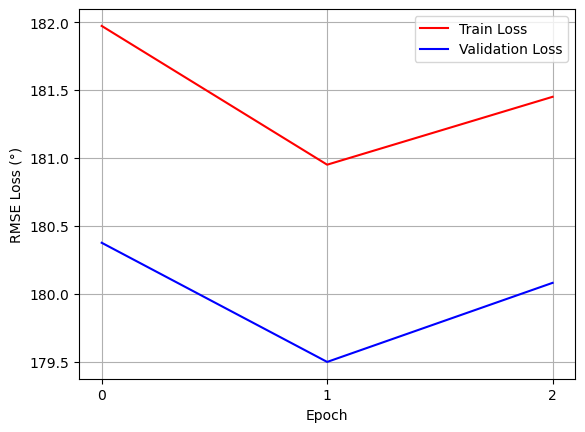

In [18]:
# Plot train/val loss
plt.figure()
plt.plot(train_rmse_deg, 'r', label='Train Loss')
plt.plot(val_rmse_deg, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss (°)')
plt.xticks(np.arange(0, n_epochs, step=max(1, n_epochs//10)))   # ensure xticks are int
plt.legend()
plt.grid()
plt.show()
